In [48]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchtext.vocab as vocab
from torchtext.data import get_tokenizer
from torchtext.datasets import SST2
from torch.utils.data import DataLoader
from torchtext.vocab import build_vocab_from_iterator
import spacy
import nlpaug.augmenter.word as naw
nlp = spacy.load("en_core_web_sm")
import OpenAttack as oa

In [49]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
%run models/SelfAttention.ipynb

In [50]:
train_iter = SST2(split="train")
val_iter = SST2(split="dev")
# test_iter = SST2(split="test")

tokenizer = get_tokenizer('spacy')
def yield_tokens(data_iter):
    for text, _ in data_iter:
        yield tokenizer(text)

vocabulary = build_vocab_from_iterator(yield_tokens(train_iter), specials=["<unk>"])
vocabulary.set_default_index(vocabulary["<unk>"])

In [51]:
glove_vectors = vocab.GloVe(name='6B', dim=100)
vocabulary.vectors = glove_vectors.get_vecs_by_tokens(vocabulary.get_itos())

In [52]:
BATCH_SIZE = 32
MAX_VOCAB_SIZE = 400000
aug = naw.AntonymAug()


def collate(x):
    batch = []
    for item in x:
        seq = []
        for word in tokenizer(item[0]):
            seq.append(vocabulary[word])
        batch.append(torch.tensor(seq))
    l = torch.tensor([item[1] for item in x]).unsqueeze(dim=1)
    return nn.utils.rnn.pad_sequence(batch, padding_value=vocabulary["<pad>"], batch_first=True), l

def collate_adv(x):
    batch = []
    for item in x:
        seq = []
        sentence = aug.augment(item[0])[0]
        for word in tokenizer(sentence):
            seq.append(vocabulary[word])
        batch.append(torch.tensor(seq))
    l = torch.tensor([item[1] for item in x]).unsqueeze(dim=1)
    return nn.utils.rnn.pad_sequence(batch, padding_value=vocabulary["<pad>"], batch_first=True), l

In [53]:
train_loader = DataLoader(train_iter, batch_size=BATCH_SIZE, collate_fn= lambda x : collate(x))
val_loader = DataLoader(val_iter, batch_size=BATCH_SIZE, collate_fn= lambda x : collate(x))

val_adv_loader = DataLoader(val_iter, batch_size=BATCH_SIZE, collate_fn= lambda x : collate_adv(x))
# test_loader = DataLoader(test_iter, batch_size=BATCH_SIZE, collate_fn= lambda x : func(x))

In [54]:
EMBEDDING_DIM = 100
HIDDEN_DIM = 256
OUTPUT_DIM = 2
DROPOUT = 0.1

model = AttentionModel(vocabulary, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM, DROPOUT)

In [55]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


print(f'The model has {count_parameters(model):,} trainable parameters')
model

The model has 56,670 trainable parameters


AttentionModel(
  (embed): Embedding(13888, 100)
  (posEncode): PositionalEncoding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (attention): SelfAttention(
    (query): Linear(in_features=100, out_features=100, bias=True)
    (key): Linear(in_features=100, out_features=100, bias=True)
    (value): Linear(in_features=100, out_features=100, bias=True)
    (softmax): Softmax(dim=2)
  )
  (fc1): Linear(in_features=100, out_features=256, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=256, out_features=2, bias=True)
  (softmax): Softmax(dim=-1)
)

## Train the Model

In [56]:
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
model = model.to(device)
model = model.float()
criterion = criterion.to(device)

In [57]:
def binary_accuracy(preds, y):
    # round predictions to the closest integer
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float()  # convert into float for division
    acc = correct.sum() / len(correct)
    return acc

In [72]:
def train(model, iterator, optimizer, criterion):
    epoch_loss = 0
    epoch_acc = 0

    model.train()
    c= 0
    for inputs, labels in iterator:
        c+=1
        inputs = inputs.to(device)
        labels = labels.view(-1).to(device)
        optimizer.zero_grad()
        predictions, _ = model(inputs)
        predictions = predictions.float()

        loss = criterion(predictions, F.one_hot(labels, num_classes=2).float())
        acc = binary_accuracy(predictions.argmax(-1), labels)

        loss.backward()

        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += acc.item()

    return epoch_loss / c, epoch_acc / c

In [73]:
def evaluate(model, iterator, criterion):
    epoch_loss = 0
    epoch_acc = 0
    c = 0
    model.eval()

    with torch.no_grad():
        for inputs,labels in iterator:
            c+=1
            inputs = inputs.to(device)
            labels = labels.view(-1).to(device)
            predictions, _ = model(inputs)
            predictions = predictions.float()
            loss = criterion(predictions, F.one_hot(labels, num_classes=2).float())
            acc = binary_accuracy(predictions.argmax(-1), labels)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
    return epoch_loss / c, epoch_acc / c

In [74]:
import time


def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [75]:
N_EPOCHS = 20

best_valid_loss = float('inf')

train_losses = []
val_losses = []
train_accuracy = []
val_accuracy = []

for epoch in range(N_EPOCHS):

    start_time = time.time()

    train_loss, train_acc = train(model, train_loader, optimizer, criterion)
    valid_loss, valid_acc = evaluate(model, val_loader, criterion)

    train_losses.append(train_loss)
    train_accuracy.append(train_acc)
    val_losses.append(valid_loss)
    val_accuracy.append(valid_acc)

    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'models/attention.pt')

    print(f'Epoch: {epoch + 1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc * 100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc * 100:.2f}%')

Epoch: 01 | Epoch Time: 50m 10s
	Train Loss: 0.369 | Train Acc: 83.42%
	 Val. Loss: 0.480 |  Val. Acc: 77.90%
Epoch: 02 | Epoch Time: 0m 15s
	Train Loss: 0.367 | Train Acc: 83.42%
	 Val. Loss: 0.489 |  Val. Acc: 76.56%
Epoch: 03 | Epoch Time: 0m 15s
	Train Loss: 0.365 | Train Acc: 83.69%
	 Val. Loss: 0.486 |  Val. Acc: 78.24%
Epoch: 04 | Epoch Time: 0m 15s
	Train Loss: 0.362 | Train Acc: 83.73%
	 Val. Loss: 0.482 |  Val. Acc: 77.34%
Epoch: 05 | Epoch Time: 0m 15s
	Train Loss: 0.364 | Train Acc: 83.63%
	 Val. Loss: 0.487 |  Val. Acc: 77.79%
Epoch: 06 | Epoch Time: 0m 16s
	Train Loss: 0.364 | Train Acc: 83.70%
	 Val. Loss: 0.481 |  Val. Acc: 78.35%
Epoch: 07 | Epoch Time: 0m 15s
	Train Loss: 0.361 | Train Acc: 83.83%
	 Val. Loss: 0.481 |  Val. Acc: 78.57%
Epoch: 08 | Epoch Time: 0m 15s
	Train Loss: 0.358 | Train Acc: 83.90%
	 Val. Loss: 0.461 |  Val. Acc: 78.01%
Epoch: 09 | Epoch Time: 0m 15s
	Train Loss: 0.359 | Train Acc: 83.91%
	 Val. Loss: 0.467 |  Val. Acc: 79.80%
Epoch: 10 | Epoch 

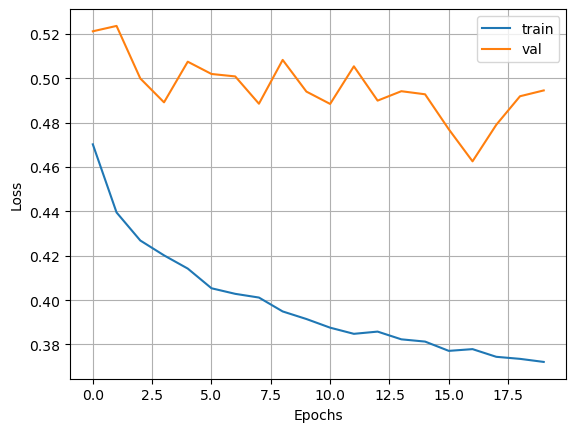

In [66]:
plt.plot(train_losses, label='train')
plt.plot(val_losses, label='val')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.show()

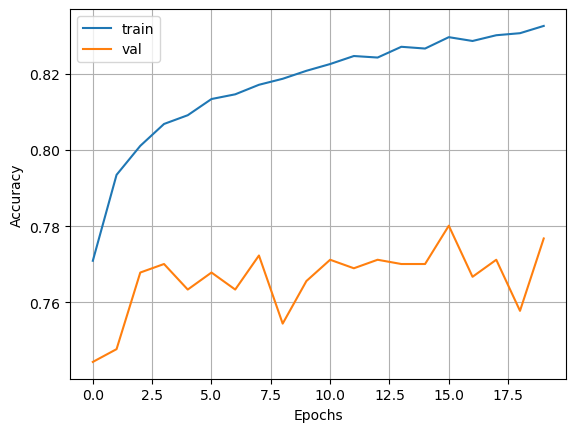

In [67]:
plt.plot(train_accuracy, label='train')
plt.plot(val_accuracy, label='val')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid()
plt.show()